In [2]:
import numpy as np
import os
from astropy.io import fits
from astropy.stats import LombScargle
from photutils import aperture_photometry as photometry
from photutils import CircularAperture as circle
from photutils import CircularAnnulus as annulus
from photutils import RectangularAperture as rectangle
from photutils import ApertureMask as mask
import matplotlib.pyplot as plt
import matplotlib as mpl
%matplotlib inline
np.set_printoptions(threshold=np.nan)


                                                Initial Setup

In [3]:
initial_directory = '/Users/Olive/Desktop/kelt pipeline/HD95735/images' # path of directory that contains full image fits files
cutout_directory = '/Users/Olive/Desktop/kelt pipeline/HD95735/cutouts/' # location for image cutouts

all_files=os.listdir(initial_directory) #extract list of files
file_count = len(all_files) # gives number of files in directory
sort_files = sorted(all_files) # sort directory in alphanumeric order
full_img_list = [os.path.join(initial_directory, sort_files[i]) for i in range(0,file_count)] # create file path names for full image files

                                                Creating Image Cutouts

In [4]:
#cell containing cutout dimensions

star_location_x =810
star_location_y =2757
size=200
cutout_x_start = int(star_location_x-size/2)
cutout_x_stop = int(star_location_x+size/2)
cutout_y_start = int(star_location_y-size/2)
cutout_y_stop = int(star_location_y+size/2)

In [4]:
# a loop to create image cutouts
for i in range(0,file_count):
    image=fits.open(full_img_list[i]) #open file
    imageData = image[1].data  #take out data from file (data is in 'section' 1)
    image.close()
    image_cutout_data= imageData[cutout_y_start:cutout_y_stop, cutout_x_start:cutout_x_stop]  #choose area of data to keep
    image_cutout = fits.PrimaryHDU(image_cutout_data)  #assign data to new fits file
    cutoutName='cutout_'+all_files[i][len(all_files[i])-20:] #appends 'cutout' to the date and id of photo
    destination=cutout_directory+cutoutName  #define destination of new file. CHANGE, GO THROUGH ALL IMAGES IN A STAR
    image_cutout.writeto(destination)  #save fits file    

OSError: File '/Users/Olive/Desktop/kelt pipeline/HD95735/cutouts/cutout_20061224.087.fits.fz' already exists.

In [5]:
# create file path names for full image files
cutout_img_list = [os.path.join(cutout_directory, sorted(os.listdir(cutout_directory))[i]) for i in range(0,file_count)]
open_cutouts =[]
for i in range (0,file_count):
    image=fits.open(cutout_img_list[i]) #open file
    imageData = image[0].data  #take out data from file (data is in 'section' 1)
    image.close()
    open_cutouts.append(imageData)

                                        Producing a Light Curve and Phase Curve

In [6]:
# cell for upcoming variables not previously defined
display_file = 0 # target file number to display target image. It can stay hardcoded, it's only for our reference

x_aperture = 9 # x coordinate of target aperture center within the star cutout 
y_aperture = 11 # y coordinate of target aperture center within the star cutout 
r = 2 # radius of target aperture

x_background = x_aperture # x coordinate of background annulus center
y_background = y_aperture # y coordinate of background annulus center
r_in = 8 # inner radius of background annulus (in pixels)
r_out = r_in + 1 # outer radius of background annulus

#a size large enough for the background annulus with 2px of padding on each side
target_img_size= (r_out+2)*2 # x by x pixel size of target image

low_period = 1.5 # lowest period for LombScargle to test on target star
high_period = 100# highest period for LombScargle to test on target star

comparison_stars= np.loadtxt('HD95735_stars.txt', skiprows=1)

cutoff_time_true= True
cutoff_time= 2457150 #if something is off with the data later on 

create images to visualize the target

In [7]:
# The following data for this star is given in the VizieR database
# name: HD 95735, period:  days, RA and dec: (11:03:20.2, +35:58:11.6), magnitude range: ()
center = len(open_cutouts[display_file])/2 # calculate center location of target image
target = open_cutouts[display_file][int(center-target_img_size/2):int(center+target_img_size/2),int(center-target_img_size/2):int(center+target_img_size/2)] # create array of target image data values for specified file
aperture_main_cutout = circle((x_aperture,y_aperture), r) # create circular aperture around target
background_main_cutout = annulus((x_background,y_background), r_in, r_out) # create annulus for background flux

#place aperture and annulus of main star on large image
offset = (len(open_cutouts[display_file])-target_img_size)/2 # calculate difference between center coordinates of target image and comparison stars image
aperture_large_cutout = circle((x_aperture+offset,y_aperture+offset), r) # place aperture on target star in comparison stars image
background_large_cutout = annulus((x_background+offset,y_background+offset), r_in, r_out) # place background annulus so that it is surrounding target star in comparison stars image

# define comparison star coordinates and radii from an existing text file 
comparison_star_circles= [] # empty list for background star circles
for i in range(len(comparison_stars)):
    newStar = comparison_stars[i] #ientify row for clearer use in the next line
    comparison_star_circles.append(circle((newStar[0],newStar[1]), r=newStar[2])) # create list of circles to plot

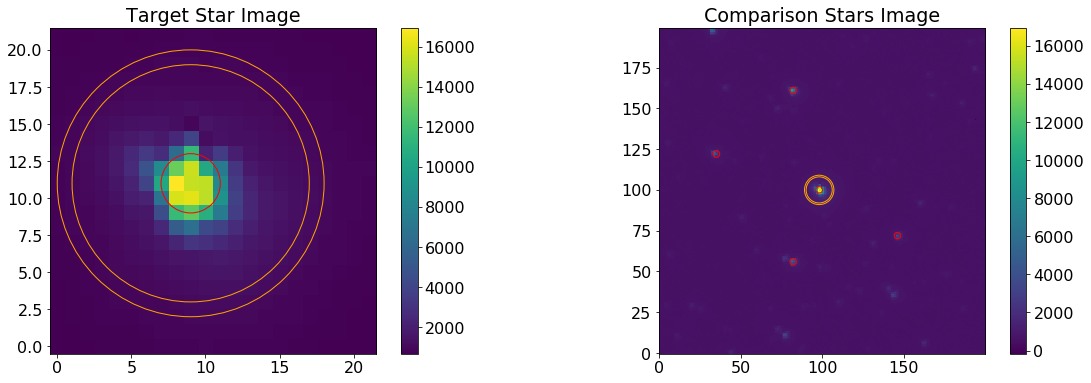

In [8]:
# create target image with target aperture and background annulus
mpl.rcParams['figure.figsize'] = (20,6)
mpl.rcParams['font.size'] = 16

def target_star_image():
    plt.subplot(121)
    plt.title('Target Star Image')
    plt.imshow(target, origin='lower')
    plt.colorbar()
    aperture_main_cutout.plot(color='red')
    background_main_cutout.plot(color='orange')

# create comparison stars image with target aperture, comparison apertures, and background annulus
def comparison_star_image():
    plt.subplot(122)
    plt.title('Comparison Stars Image')
    plt.imshow(open_cutouts[display_file], origin='lower')
    plt.colorbar()
    aperture_large_cutout.plot(color='red')
    background_large_cutout.plot(color='orange')
    for i in range(len(comparison_star_circles)):
        comparison_star_circles[i].plot(color='red')

target_star_image()
comparison_star_image()
plt.show()


Flux of star v. Time plot

In [9]:
background_mask = background_large_cutout.to_mask(method='center') # create mask over pixels in background annulus that have their centers within the annulus 
background_data = [background_mask[0].multiply(open_cutouts[i]) for i in range(0,file_count)] # create array of flux values with zero values corresponding to data outside the mask and nonzero values corresponding to the data within the mask 
background_flux = [background_data[i][background_mask[0].data > 0] for i in range(0,file_count)] # create array of flux values contained in mask
background_median = [np.median(background_flux[i]) for i in range(0,file_count)] # find median of background flux array

# create target flux vs. time plot
target_sum = [photometry(open_cutouts[i], aperture_large_cutout, method = 'exact') for i in range(0,file_count)] # sum up exact amount of flux contained in the target aperture
target_background_sum = [background_median[i] * aperture_large_cutout.area() for i in range(0,file_count)] # multiply background median by area of aperture to get background flux contained in aperture
target_subtract = np.array([target_sum[i]['aperture_sum'] - target_background_sum[i] for i in range(0,file_count)]) # subtract background flux in aperture from aperture's total flux

target_flux = target_subtract[target_subtract != 0] # disregard zero and below flux values 

time=[]
for i in range(0,len(target_flux)):
    original_file = fits.open(full_img_list[i])
    time.append(original_file[1].header['JDT'])
    original_file.close
    
normalized_target_flux = target_flux/max(target_flux)          
    
if cutoff_time_true == True:
    cut_time=[]
    for i in range(0,len(time)):
        if time[i]<cutoff_time:
            cut_time.append(time[i])
    cut_flux=target_flux[:len(cut_time)]
    normalized_target_flux = cut_flux/max(cut_flux)          
else: 
    normalized_target_flux = target_flux/max(target_flux)


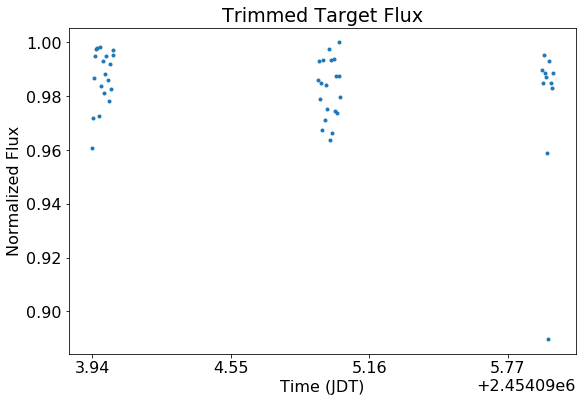

In [64]:
#create flux v. time plot
plt.subplot(121)
plt.xlabel('Time (JDT)')
plt.ylabel('Normalized Flux')
      
#rounding x tick marks
roundDecimals=2
difference=(max(cut_time)+1-min(cut_time))
while difference>=10:
    difference= difference/10
    roundDecimals=roundDecimals-1
if difference<=1:   
    roundDecimals=roundDecimals-2
    while difference<=1:
        difference= difference/10
        roundDecimals=roundDecimals+1
        
#plotting
if cutoff_time_true == True:
    plt.title('Trimmed Target Flux')
    plt.xticks(np.arange(round(min(cut_time),roundDecimals), max(cut_time)+1, round((max(cut_time)+1-min(cut_time))/5,roundDecimals)))
    plt.plot(cut_time, normalized_target_flux, '.')
else:
    plt.title('Target Flux') 
    plt.xticks(np.arange(round(min(time),roundDecimals), max(time)+1, round((max(time)+1-min(time))/5,roundDecimals)))
    plt.plot(time, normalized_target_flux, '.')



find point cutoff point in time and find why they dont fit in after
list of inages and their values 

comparison flux v. time plot

In [66]:
# sum up exact amount of flux contained in each comparison star aperture
comparison_sum = [[photometry(open_cutouts[i], comparison_star_circles[j], method = 'exact') 
                   for i in range(0, file_count)] for j in range(0,len(comparison_star_circles))]

# multiply background median by area of each aperture to get background flux contained in each aperture
comparison_background_sum = [[background_median[i] * comparison_star_circles[j].area() 
                              for i in range(0, file_count)] for j in range(0,len(comparison_star_circles))]

# subtract background flux in each aperture from each aperture's total flux
comparison_subtract = np.array([[comparison_sum[j][i]['aperture_sum'] - comparison_background_sum[j][i] 
                                 for i in range(0,file_count)] for j in range(0,len(comparison_star_circles))]) 

comparison_total = comparison_subtract.sum(axis=0) # sum up the background subtracted flux for all comparison stars
comparison_flux = comparison_total[comparison_total != 0] # disregard zero flux values

if cutoff_time_true == True:
    cut_comparison_flux=comparison_flux[:len(cut_time)]
    normalized_comparison_flux= cut_comparison_flux/max(cut_comparison_flux)
    
else:
    normalized_comparison_flux= comparison_flux/max(comparison_flux)


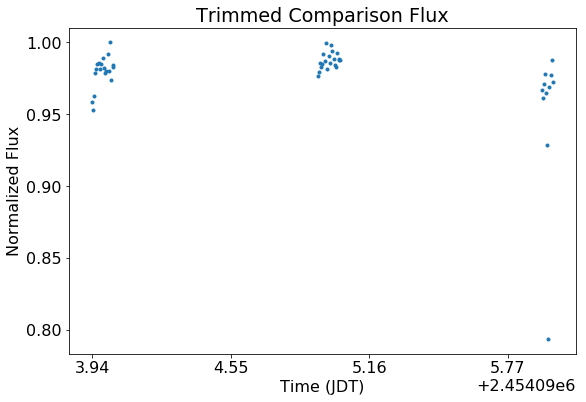

In [67]:
# create comparison flux vs. time plot
plt.subplot(122)
plt.xlabel('Time (JDT)')
plt.ylabel('Normalized Flux')

if cutoff_time_true == True:   
    plt.title('Trimmed Comparison Flux')
    plt.xticks(np.arange(round(min(cut_time),roundDecimals), max(cut_time)+1, round((max(cut_time)+1-min(cut_time))/5,roundDecimals)))
    plt.plot(cut_time, normalized_comparison_flux, '.')

else:
    plt.title('Comparison Flux')
    plt.xticks(np.arange(round(min(time),roundDecimals), max(time)+1, round((max(time)+1-min(time))/5,roundDecimals)))
    plt.plot(time, normalized_comparison_flux, '.')

target light curve minus comparison flux v. time 

target periodogram with power v. period

target phase curve with flux v. phase

In [68]:
# subtract target flux from comparison flux then use Lomb-Scargle Periodogram to test period range on target 

if cutoff_time_true == True:
    final_flux = np.subtract(cut_flux, cut_comparison_flux)
    frequency, power = LombScargle(cut_time, final_flux).autopower(minimum_frequency = 1/high_period, maximum_frequency = 1/low_period)
else:
    final_flux = np.subtract(target_flux, comparison_flux) 
    frequency, power = LombScargle(time, final_flux).autopower(minimum_frequency = 1/high_period, maximum_frequency = 1/low_period)
    
best_frequency = frequency[np.argmax(power)] # find frequency with highest power value
period = 1/best_frequency # convert this frequency to a period
low = np.argmin(final_flux) # find lowest value of flux 

if cutoff_time_true == True:
    phase_offset = 0.5 - np.remainder(cut_time[low], period) / period # calculate phase offset so that lowest flux value in each cycle is located at half the period
    phase = np.remainder(cut_time + phase_offset * period, period * 2) / period # calculate the phase of the target flux for two cycles

else:
    phase_offset = 0.5 - np.remainder(time[low], period) / period # calculate phase offset so that lowest flux value in each cycle is located at half the period
    phase = np.remainder(time + phase_offset * period, period * 2) / period # calculate the phase of the target flux for two cycles


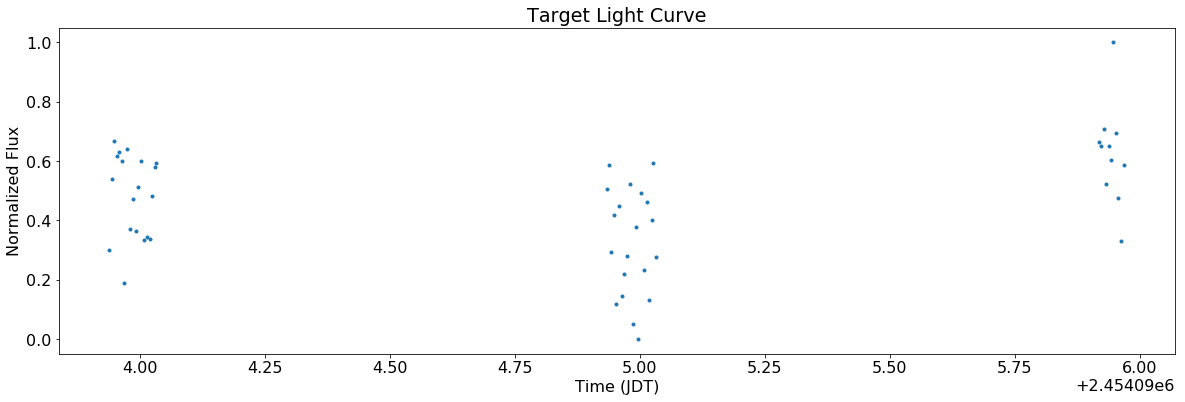

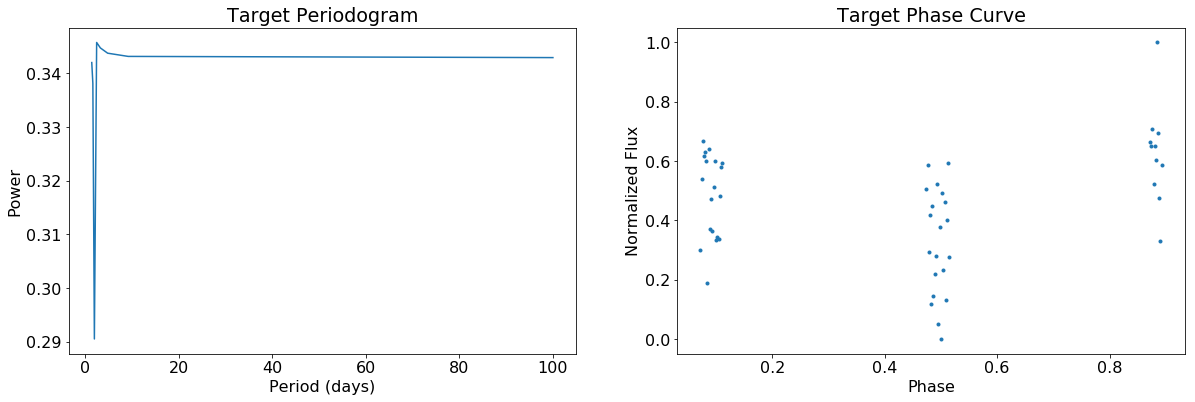

best period for range 1.5 to 100 days = 2.4743536504334003 days
power value for best period =  0.34576996164329193


In [69]:
# create target light curve with target flux minus comparison flux vs. time 
plt.title('Target Light Curve')
plt.xlabel('Time (JDT)')
plt.ylabel('Normalized Flux')
#plt.xticks(np.arange(round(min(time),-2), max(time)+1, round((max(time)+1-min(time))/10,-2)))
if cutoff_time_true == True:
    plt.plot(cut_time, (final_flux - min(final_flux))/(max(final_flux)-min(final_flux)), '.') 
else:
    plt.plot(time, (final_flux - min(final_flux))/(max(final_flux)-min(final_flux)), '.') 
plt.show()

# create target periodogram with power vs. period
plt.subplot(121)
plt.plot(1/frequency, power)
plt.title('Target Periodogram')
plt.xlabel('Period (days)')
plt.ylabel('Power')

# create target phase curve with flux vs. phase
plt.subplot(122)
plt.plot(phase, (final_flux - min(final_flux))/max(final_flux-min(final_flux)), '.')
plt.title('Target Phase Curve')
plt.xlabel('Phase')
plt.ylabel('Normalized Flux')
plt.show()

# print the most likely period with its corresponding power value for the target star

print("best period for range", low_period, "to", high_period, "days =", period, "days")
print("power value for best period = ", max(power))

                                                Creating Flux Histogram

In [70]:
# cell for upcoming variables not previously defined

bin_size = 5000 # bin size for histogram

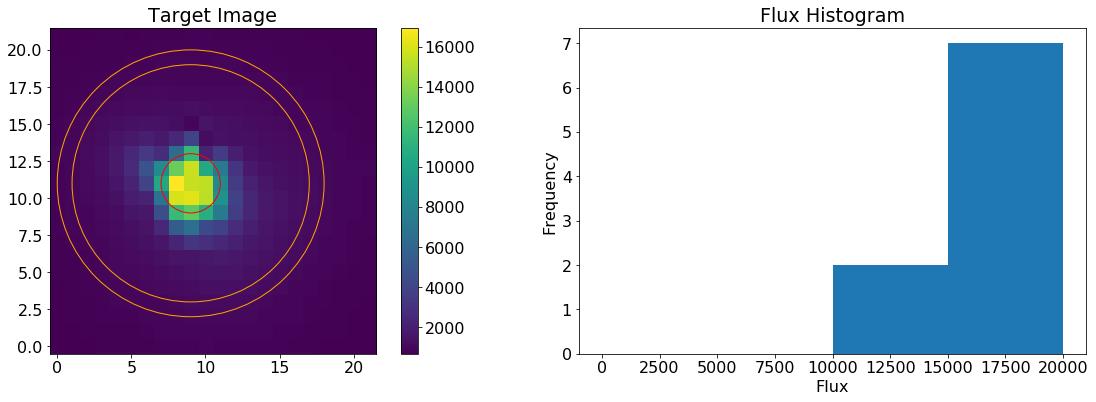

In [71]:
# create target image with target aperture and background annulus

plt.subplot(121)
plt.title('Target Image')
plt.imshow(target, origin='lower')
plt.colorbar()
aperture_main_cutout.plot(color='red')
background_main_cutout.plot(color='orange')

aperture_mask = aperture_main_cutout.to_mask(method='center') # create mask over pixels in target aperture that have their centers within the annulus 
aperture_data = aperture_mask[0].multiply(target) # create array of flux values with zero values corresponding to data outside the mask and nonzero values corresponding to the data within the mask 
aperture_flux = aperture_data[aperture_mask[0].data > 0] # create array of flux values contained in mask

# create bins for histogram up to highest flux value in aperture
bins = np.arange(0,max(np.ndarray.flatten(target)+bin_size),bin_size) 

# create flux histrogram of values within target aperture
plt.subplot(122)
plt.hist(aperture_flux, bins);
plt.title('Flux Histogram')
plt.xlabel('Flux')
plt.ylabel('Frequency');
plt.show()

                                            Examining Abnormal Flux Values

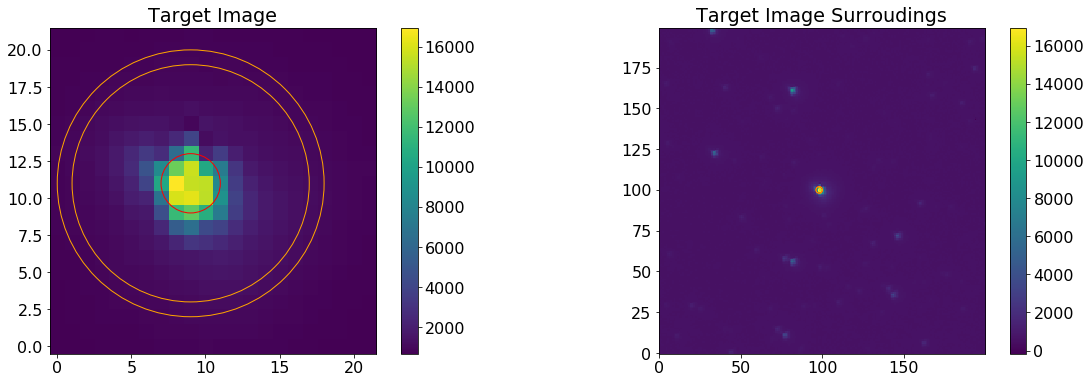

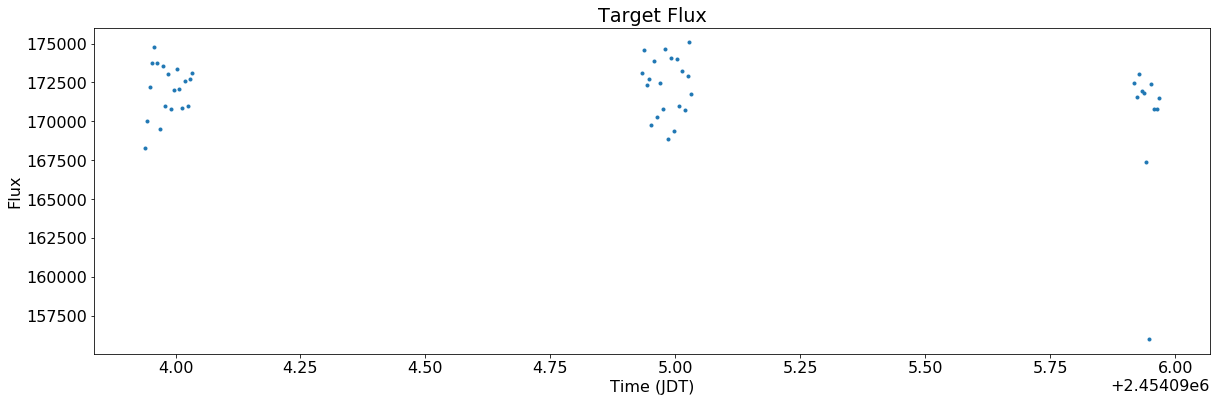

Low Flux Values

File    Target Flux



High Flux Values

File    Target Flux


In [72]:

# create target image with target aperture and background annulus
plt.subplot(121)
plt.title('Target Image')
plt.imshow(target, origin='lower')
plt.colorbar()
aperture_main_cutout.plot(color='red')
background_main_cutout.plot(color='orange')

mpl.rcParams['figure.figsize'] = (20,6)
mpl.rcParams['font.size'] = 16

target_data = [open_cutouts[i][int(center-target_img_size/2):int(center+target_img_size/2),int(center-target_img_size/2):int(center+target_img_size/2)] for i in range(0,file_count)] # create array of target image data values for all files
target_sum = [photometry(target_data[i], aperture_main_cutout, method = 'exact') for i in range(0,file_count)] # sum up exact amount of flux contained in the target aperture
target_flux = np.array([target_sum[i]['aperture_sum'] for i in range (0,file_count)]) # get flux of target aperture without disregarding zero flux values


# create surrounding area image with target aperture and background annulus

plt.subplot(122)
plt.title('Target Image Surroudings')
plt.imshow(open_cutouts[display_file], origin='lower')
plt.colorbar() 
aperture_large_cutout.plot(color='red') 
aperture_large_cutout.plot(color='orange')
plt.show()

#redefine time to contain timestamps even of 0 flux images
alltime=[]
for i in range(0,len(open_cutouts)):
    original_file = fits.open(full_img_list[i])
    alltime.append(original_file[1].header['JDT'])
    original_file.close

# create light curve for target flux with zero flux values

plt.title('Target Flux')
plt.xlabel('Time (JDT)')
plt.ylabel('Flux')
#plt.xticks(np.arange(round(min(alltime),-2), max(alltime)+1, round((max(alltime)+1-min(alltime))/10,-2)))
plt.plot(alltime, target_flux, '.')
plt.show()


low_flux = 100000
high_flux = np.inf # upper limit for target flux values


# print flux values and corresponding file number for values that fall outside specified limits

print("Low Flux Values")
print("")
print("File    Target Flux")
for i in range(0,len(target_flux[target_flux < low_flux])):
    print(np.add(np.where(target_flux < low_flux),1)[0][i], "        ", target_flux[target_flux < low_flux][i])
print("")
print("")
print("")
print("High Flux Values")
print("")
print("File    Target Flux")
for i in range(0,len(target_flux[target_flux > high_flux])):
    print(np.add(np.where(target_flux > high_flux),1)[0][i], "        ", target_flux[target_flux > high_flux][i])